# Excitatory Intrinsic Plasticity (EXC-IP)

## Design - Single Neuron

Assume exists $N$ rate neurons with activities $X_i(t)$. We want to study how intrinsic excitatory plasticity affects the way the neurons remember patterns. 

Let's add some ingredients.

1. ODE: We shall start with $$\tau \dot{X} = f(X, ...)$$
2. Input: Use instant response. More generally, could use convolution with neuronal response
$$\tau \dot{X} = I(t) + ...$$
3. Leak: In the absence of input, activity should return to 0. In presence of input, cell must achieve stable firing rate
$$\tau \dot{X} = -X(t) + I(t) + ...$$
4. EXC-IP: Excitability is how strongly does activity respond to input. So it is multiplicative to input. Excitability itself can be a slowly-changing function of input
$$\tau_X \dot{X} = -X(t) + E(t)I(t) + ...$$
$$\tau_E \dot{E} = X(t) - X_0 E(t)$$
Ok, this does not work. The above equations do not have a stable fixed point, but instead unbounded growth due to positive feedback loop. Excitability must be bounded, as it is pointless to allow a cell to be infinitely excitable or not excitable at all. The target steady state excitability we want to achieve can be written using a sigmoid
$$E_{st}(X) = 1 + (g_E - 1)\sigma \biggl( \frac{X - X_{\mu}}{s} \biggr)$$
where $g_E$ is the maximal gain of excitability (eg $g_E=2$ would make the cell at most twice as excitable), $X_{\mu}$ is a firing rate somewhere inbetween maximal and minimal firing rate, and $s$ is a slope parameter, determining how sensitive excitability is to changes of firing rate. Thus, the excitation plasticity can be given by
$$\tau_E \dot{E} = E_{st}(X) - E$$
It can be shown that for a constant input $I$ and sufficiently narrow $s$, the steady state firing rate is
  * If $I \ll X_{\mu}$, then $X_{st} \approx I$
  * If $I \gg X_{\mu}$, then $X_{st} \approx g_E I$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Append base directory
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
path1p = os.path.dirname(currentdir)
path2p = os.path.dirname(path1p)
libpath = os.path.join(path2p, "lib")

sys.path.insert(0, libpath)
print("Appended library directory", libpath)

from opencv_lib import cvWriter

Appended library directory /media/aleksejs/DataHDD/work/codes/theoretical-models/behavioural-neural/memory-hippo-ca3/lib


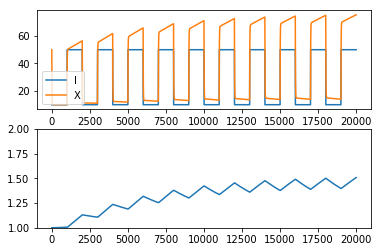

In [4]:
def sig(x):
    return 1 / (1 + np.exp(-x))

def E_ST(X, p):
    return 1 + (p['g_E'] - 1)*sig((X - p['X_mu'])/p['X_s'])

def RHS_XE(X, E, I, p):
    rhs_X = (E * I - X) / p['tau_X']
    rhs_E = (E_ST(X, p) - E) / p['tau_E']
    return rhs_X, rhs_E

p = {
    'tau_X' : 10.0,     # ms, neuronal timescale
    'tau_E' : 4000.0,   # ms, EXC_IP timescale
    'g_E'   : 2.0,      # excitatory gain
    'X_mu'  : 50.0,     # mV, average firing rate
    'X_s'   : 10.0,     # mV, EXC_IP sensitivity
    'I_min' : 10.0,     # mV, min input
    'I_max' : 50.0,     # mV, max input
    'dt'    : 0.1,      # ms, discretization time
    'T'     : 20000.0,  # ms, simulation time
    'T_Inp' : 1000.0    # ms, frequency of input change
}

t_arr = np.arange(0, p['T'], p['dt'])
I_arr = p['I_min'] + (p['I_max'] - p['I_min']) * ((t_arr / p['T_Inp']).astype(int) % 2 == 1).astype(float)

###################
# Simulate
###################

N_STEP = t_arr.shape[0]
X_arr = np.zeros(N_STEP)
E_arr = np.zeros(N_STEP)
X_arr[0] = p['X_mu']
E_arr[0] = 1.0

for i in range(1, N_STEP):
    VX, VE = RHS_XE(X_arr[i-1], E_arr[i-1], I_arr[i-1], p)
    X_arr[i] = X_arr[i-1] + VX * p['dt']
    E_arr[i] = E_arr[i-1] + VE * p['dt']


fig,ax = plt.subplots(nrows=2)
ax[0].plot(t_arr, I_arr, label='I')
ax[0].plot(t_arr, X_arr, label='X')
ax[0].legend()
ax[1].plot(t_arr, E_arr, label='E')
ax[1].set_ylim(1.0, p['g_E'])
plt.show()

## Design - Network

Ok, so we have a stable neuron, that becomes more or less excitable based on average input it has received over recent past. We can control excitability in terms of its timescale, gain and sensitivity to activity change. Now, why do we care about having such a neuron? Let's construct a boring network and see how it reacts to some input patterns. First, we want to see how this network will behave without excitability, so we will ignore it for now. So the input is now also received from a random subselection of neurons
$$\tau \dot{X}_i = -X_i + I_i + W_{ij} X_j$$
The problem is that making this system stable is non-trivial. One way is to set $\rho(W) < 1$. That would ensure that the system decays in absence of input. However, in presence of input, the system may still be unstable. Thus, additional stabilizing mechanisms are necessary. A natural mechanism is inhibition. My previous observations suggest that linear inhibition does not do the trick. It is either not enough and the system still blows up, or it is too much, and the system's activity may rapidly drop to 0 in a chaotic manner. Hence, we will use nonlinear inhibition, which is progressively stronger with input

$$
\begin{eqnarray}
\tau_X \dot{X}_i &=& -X_i + I_i + W^{EE}_{ij} X_j - W^{IE}_{ij} Y_j \\
\tau_Y \dot{Y}_i &=& -Y_i + f_I(W^{EI}_{ij} X_j)
\end{eqnarray}
$$

Here $f_I(x)$ can be any supra-linear function, e.g. $f(x) = x_0 \bigl( \frac{x}{x_0} \bigr)^n$. It should still be measured in mV, so the nonlinear operation must apply to a dimensionless quantity

spectral radius was 199.5838794871802
norm was 115.00866645990035 115.36649469258656
norm became 2.3088486397335704 0.5774335284774719


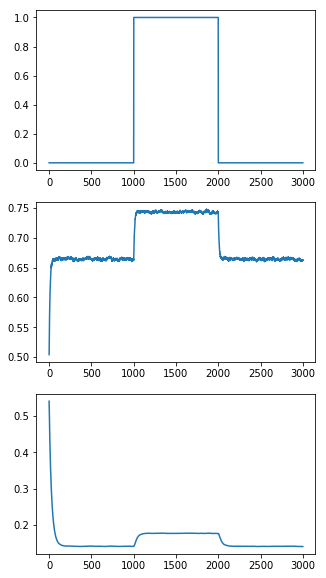

In [37]:
def nonlinY(X, p):
    return X**2 / p['I_max']

def RHS_XY(X, Y, I, p):
    rhs_X = (-X + sig(I + p['W_EE'].dot(X) - p['W_IE'].dot(Y))) / p['tau_X']
    rhs_Y = (-Y + nonlinY(p['W_EI'].dot(X), p))  / p['tau_Y']
    return rhs_X, rhs_Y


p = {
    'NINP'  : (20,20),  # pixel
    'NX'    : 400,      # Number of excitatory neurons
    'NY'    : 100,      # Number of excitatory neurons
    'tau_X' : 10.0,     # ms, EXC neuronal timescale
    'tau_Y' : 30.0,     # ms, INH neuronal timescale
    'I_min' : 10.0,     # mV, min input
    'I_max' : 50.0,     # mV, max input
    'dt'    : 0.1,      # ms, discretization time
    'T'     : 3000.0,  # ms, simulation time
    'T_Inp' : 1000.0    # ms, frequency of input change
}

####################
#  Connections
####################
p['W_EE'] = np.random.uniform(0, 1, (p['NX'], p['NX']))
p['W_EI'] = np.random.uniform(0, 1, (p['NY'], p['NX']))
p['W_IE'] = np.random.uniform(0, 1, (p['NX'], p['NY']))

# Set spectral radius of self-connections to 1
RHO_EE = np.max(np.real(np.linalg.eig(p['W_EE'])[0]))
p['W_EE'] /= RHO_EE
print('spectral radius was', RHO_EE)

# Set all EI and IE connections to sum up to 1
print('norm was', np.linalg.norm(p['W_EI']), np.linalg.norm(p['W_IE']))

for i in range(p['NX']):
    p['W_EI'][:, i] /= np.sum(p['W_EI'][:, i])
    
for i in range(p['NY']):
    p['W_IE'][:, i] /= np.sum(p['W_IE'][:, i])

print('norm became', np.linalg.norm(p['W_EI']), np.linalg.norm(p['W_IE']))

###################
# Input
###################

t_arr = np.arange(0, p['T'], p['dt'])
I_arr = ((t_arr / p['T_Inp']).astype(int) % 2 == 1).astype(float)

I_template = np.zeros(p['NINP'])
I_template[:10, :10] = 1.0

I_arr_img = p['I_min'] + (p['I_max'] - p['I_min']) * np.outer(I_arr, I_template.flatten())
I_arr_img += np.random.normal(0, p['I_max']/2, I_arr_img.shape)


###################
# Simulate
###################

N_STEP = t_arr.shape[0]
X_arr = np.zeros((N_STEP, p['NX']))
Y_arr = np.zeros((N_STEP, p['NY']))
X_arr[0] = np.random.uniform(0, 1, p['NX'])
Y_arr[0] = np.random.uniform(0, 1, p['NY'])

for i in range(1, N_STEP):
    VX, VY = RHS_XY(X_arr[i-1], Y_arr[i-1], I_arr_img[i-1], p)
    X_arr[i] = X_arr[i-1] + VX * p['dt']
    Y_arr[i] = Y_arr[i-1] + VY * p['dt']
    
X_nrm = np.mean(X_arr, axis=1)
Y_nrm = np.mean(Y_arr, axis=1)
    
fig,ax = plt.subplots(nrows=3, figsize=(5, 10))
ax[0].plot(t_arr, I_arr, label='I')
ax[1].plot(t_arr, X_nrm, label='X')
ax[2].plot(t_arr, Y_nrm, label='Y')
plt.show()

Ok, so it behaves as a damped harmonic oscillator, nice. Now we need some test to figure out how well it preserves the original image

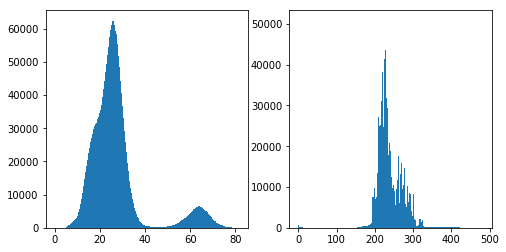

In [30]:
# Figure out what is the range of interest
fig, ax = plt.subplots(ncols=2, figsize=(8,4))
ax[0].hist(X_arr.flatten(), bins='auto')
ax[1].hist(Y_arr.flatten(), bins='auto')
plt.show()

In [31]:
THR_LEFT = 0
THR_RIGHT = 80

mat = X_arr.reshape((N_STEP,) + p['NINP'])
mat = ((mat - THR_LEFT) / THR_RIGHT * 255).astype(int)
mat[mat < 0] = 0
mat[mat > 255] = 255

with cvWriter('./test123.avi', p['NINP'], frate=100.0, codec='MJPG') as cv1:
    for i in range(N_STEP):
        cv1.write(mat[i])

As expected, the original image quickly diappears from the network

# Combine IP with Network

spectral radius was 200.14744316164794
norm was 115.69979499169155 115.97271720038509
norm became 2.310084551497631 0.5769466326744302


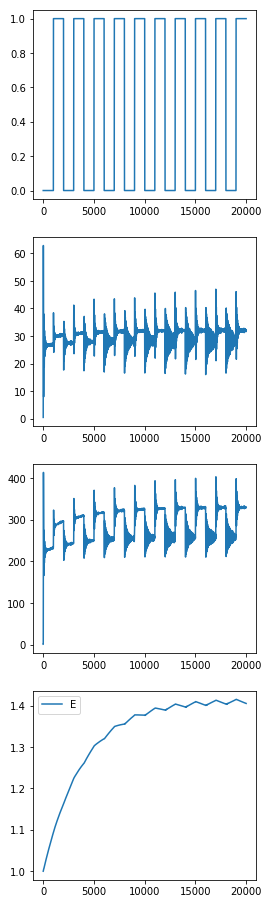

In [36]:
def RHS_XYE(X, Y, E, I, p):
    INP_X = I + p['W_EE'].dot(X) - p['W_IE'].dot(Y)
    rhs_X = (-X + p['x_max']*E*sig(INP_X / p['x_slope'])) / p['tau_X']
    rhs_Y = (-Y + nonlinY(p['W_EI'].dot(X), p))  / p['tau_Y']
    rhs_E = (E_ST(X, p) - E) / p['tau_E']
    return rhs_X, rhs_Y, rhs_E

p = {
    'NINP'  : (20,20),  # pixel
    'NX'    : 400,      # Number of excitatory neurons
    'NY'    : 100,      # Number of excitatory neurons
    'tau_X' : 10.0,     # ms, EXC neuronal timescale
    'tau_Y' : 30.0,     # ms, INH neuronal timescale
    'tau_E' : 4000.0,   # ms, EXC_IP timescale
    'x_max' : 100.0,    # mV, maximum firing rate
    'x_slope' : 10.0,   # mV, sigmoidal conversion from input to state
    'I_min' : 10.0,     # mV, min input
    'I_max' : 50.0,     # mV, max input
    'g_E'   : 2.0,      # excitatory gain
    'X_mu'  : 30.0,     # mV, average firing rate
    'X_s'   : 10.0,     # mV, EXC_IP sensitivity
    'dt'    : 0.1,      # ms, discretization time
    'T'     : 20000.0,  # ms, simulation time
    'T_Inp' : 1000.0    # ms, frequency of input change
}

####################
#  Connections
####################
p['W_EE'] = np.random.uniform(0, 1, (p['NX'], p['NX']))
p['W_EI'] = np.random.uniform(0, 1, (p['NY'], p['NX']))
p['W_IE'] = np.random.uniform(0, 1, (p['NX'], p['NY']))

# Set spectral radius of self-connections to 1
RHO_EE = np.max(np.real(np.linalg.eig(p['W_EE'])[0]))
p['W_EE'] /= RHO_EE
print('spectral radius was', RHO_EE)

# Set all EI and IE connections to sum up to 1
print('norm was', np.linalg.norm(p['W_EI']), np.linalg.norm(p['W_IE']))

for i in range(p['NX']):
    p['W_EI'][:, i] /= np.sum(p['W_EI'][:, i])
    
for i in range(p['NY']):
    p['W_IE'][:, i] /= np.sum(p['W_IE'][:, i])

print('norm became', np.linalg.norm(p['W_EI']), np.linalg.norm(p['W_IE']))

###################
# Input
###################

t_arr = np.arange(0, p['T'], p['dt'])
I_arr = ((t_arr / p['T_Inp']).astype(int) % 2 == 1).astype(float)

I_template = np.zeros(p['NINP'])
I_template[:10, :10] = 1.0

I_arr_img = p['I_min'] + (p['I_max'] - p['I_min']) * np.outer(I_arr, I_template.flatten())
I_arr_img += np.random.normal(0, p['I_max']/2, I_arr_img.shape)


###################
# Simulate
###################

N_STEP = t_arr.shape[0]
X_arr = np.zeros((N_STEP, p['NX']))
E_arr = np.zeros((N_STEP, p['NX']))
Y_arr = np.zeros((N_STEP, p['NY']))
X_arr[0] = np.random.uniform(0, 1, p['NX'])
Y_arr[0] = np.random.uniform(0, 1, p['NY'])
E_arr[0] = np.ones(p['NX'])

for i in range(1, N_STEP):
    VX, VY, VE = RHS_XYE(X_arr[i-1], Y_arr[i-1], E_arr[i-1], I_arr_img[i-1], p)
    X_arr[i] = X_arr[i-1] + VX * p['dt']
    Y_arr[i] = Y_arr[i-1] + VY * p['dt']
    E_arr[i] = E_arr[i-1] + VE * p['dt']
    
X_nrm = np.mean(X_arr, axis=1)
Y_nrm = np.mean(Y_arr, axis=1)
E_nrm = np.mean(E_arr, axis=1)
    
fig,ax = plt.subplots(nrows=4, figsize=(4, 16))
ax[0].plot(t_arr, I_arr, label='I')
ax[1].plot(t_arr, X_nrm, label='X')
ax[2].plot(t_arr, Y_nrm, label='Y')
ax[3].plot(t_arr, E_nrm, label='E')
plt.legend()
plt.show()